In [2]:
import sys

sys.path.insert(1, "C:/Users/Uporabnik/Documents/IJS-F9/korlz")

In [3]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from ml.common.data_utils.data_modules import HiggsDataset
from ml.common.data_utils.syn_datacreator import create_custom_multidim_dataset
from ml.common.utils.loggers import timeit, log_num_trainable_params, setup_logger

from ml.diffusion.EDM.losses import EDMLoss
from ml.diffusion.EDM.samplers import edm_sampler
from ml.diffusion.EDM.model import SimpleUNet, EDMPrecond

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\Uporabnik\Documents\IJS-F9\JanGit\MLHEPsim-master\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Uporabnik\Documents\IJS-F9\korlz\ml\diffusion\EDM


device(type='cpu')

Synthetic data

In [4]:
batch_size = 512

In [5]:
N_FEATURES = 3

datasetraw = create_custom_multidim_dataset(
    n_samples=20000, n_features=N_FEATURES, label_random=True, signal_frac=0.5, seed=123
)
print("dataset shape:", datasetraw.shape)  # (10000, 3)
print(datasetraw[:5])

dataset shape: (20000, 4)
[[-3.550892  -1.0142367 -7.4624577  0.       ]
 [ 4.622796   1.6087942  3.7642446  1.       ]
 [-4.515475  -2.5092688 -3.500204   0.       ]
 [-4.6891136 -4.7863035 -4.834843   0.       ]
 [-3.4597535 -3.6463473 -4.970148   0.       ]]


In [6]:
features_syn = [f"f{i}" for i in range(N_FEATURES)]

In [7]:
# X_syn, labels_syn = datasetraw[:, :-1], datasetraw[:, -1][:, None]
train_data_syn, val_data_syn = train_test_split(datasetraw, train_size=0.8)

print(train_data_syn.shape, val_data_syn.shape)
train_dataset_syn = HiggsDataset(train_data_syn)
val_dataset_syn = HiggsDataset(val_data_syn)

batches_train = DataLoader(
    train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True
)
batches_val = DataLoader(
    train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True
)

X_syn, labels_syn = next(iter(batches_train))

sigma_data = X_syn.std().numpy()

# fig, ax = plt.subplots(N_FEATURES, 1)
# for idx, feature in enumerate(features_syn[:N_FEATURES]):
#     sns.histplot(X_syn[:, idx][:, None], bins=30, ax=ax[idx])
# plt.show()

(16000, 4) (4000, 4)


In [8]:
# prep noise scales
N_NOISE_SCALES = 10

# noise_scales = linear_noise_scale(length=N_NOISE_SCALES).to(device)
# noise_scales = geometric_noise_scale(start=1., end=0.01, length=N_NOISE_SCALES).to(device)

# reshape data
IMG_SHAPE = (1, 3, 1)
assert np.prod(IMG_SHAPE) == N_FEATURES, "Image shape must match number of features"

raw_model = SimpleUNet(in_channels=IMG_SHAPE[0]).to(device)
modelsmall = EDMPrecond(raw_model, sigma_data=sigma_data).to(device) 

log_num_trainable_params(modelsmall, unit="k")

243297

In [9]:
# loss test
batch, _ = next(iter(batches_train))
reshaped_features = batch.view(-1, *IMG_SHAPE)
loss_fn = EDMLoss(sigma_data=sigma_data)

loss = loss_fn(modelsmall, reshaped_features)
L = loss.sum().mul(1 / batch_size)
print(L.item())

3.102738380432129


In [10]:
def train(model, train_dataloader, val_dataloader, device, max_epochs=10, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)
    loss_fn = EDMLoss(sigma_data=sigma_data)

    epoch_train_loss = []
    epoch_val_loss = []

    for epoch in range(max_epochs):
        model.train()
        train_loss = []
        loop = tqdm(
            train_dataloader, leave=False, desc=f"Epoch {epoch+1}/{max_epochs} training"
        )

        for features_batch, _ in loop:
            optimizer.zero_grad()
            features_batch = features_batch.to(device)
            reshaped_features = features_batch.view(
                -1, *IMG_SHAPE
            )  # -> (batch_size, 1, 3, 1)

            loss_tensor = loss_fn(model, reshaped_features)
            # loss = loss_tensor.sum().mul(1 / batch_size)
            loss = loss_tensor.mean()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            loop.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        epoch_avg = float(np.mean(train_loss)) if len(train_loss) > 0 else 0.0
        epoch_train_loss.append(epoch_avg)
        current_lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1}/{max_epochs} | avg_loss={epoch_avg:.4f} | LR={current_lr:.6f}"
        )

        model.eval()
        val_loss = []
        loop_val = tqdm(
            val_dataloader, leave=False, desc=f"Epoch {epoch+1}/{max_epochs} validation"
        )
        with torch.no_grad():
            for features_batch_val, _ in loop_val:
                features_batch_val = features_batch_val.to(device)
                reshaped_features_val = features_batch_val.view(
                    -1, *IMG_SHAPE
                )  # -> (batch_size, 1, 3, 1)

                loss_val_tensor = loss_fn(model, reshaped_features_val)
                loss_val = loss_val_tensor.mean()
                val_loss.append(loss_val.item())
                loop_val.set_postfix({"val_batch_loss": f"{loss_val.item():.4f}"})

        epoch_avg_val = float(np.mean(val_loss)) if len(val_loss) > 0 else 0.0
        epoch_val_loss.append(epoch_avg_val)
        print(f"Epoch {epoch+1}/{max_epochs} | avg_loss_val={epoch_avg_val:.4f}")

        # sch update
        scheduler.step()

    return model, epoch_train_loss, epoch_val_loss

In [11]:
model_trained, epoch_train_loss, epoch_val_loss = train(
    modelsmall, batches_train, batches_val, device, max_epochs=40, lr=1e-4
)

Epoch 1/40 | avg_loss=0.7916 | LR=0.000100


Epoch 1/40 | avg_loss_val=0.7313


Epoch 2/40 | avg_loss=0.6999 | LR=0.000100


Epoch 2/40 | avg_loss_val=0.7002


Epoch 3/40 | avg_loss=0.6968 | LR=0.000099


Epoch 3/40 | avg_loss_val=0.6876


Epoch 4/40 | avg_loss=0.6761 | LR=0.000099


Epoch 4/40 | avg_loss_val=0.6804


Epoch 5/40 | avg_loss=0.6837 | LR=0.000098


Epoch 5/40 | avg_loss_val=0.6748


Epoch 6/40 | avg_loss=0.6691 | LR=0.000096


Epoch 6/40 | avg_loss_val=0.6750


Epoch 7/40 | avg_loss=0.6657 | LR=0.000095


Epoch 7/40 | avg_loss_val=0.6644


Epoch 8/40 | avg_loss=0.6672 | LR=0.000093


Epoch 8/40 | avg_loss_val=0.6615


Epoch 9/40 | avg_loss=0.6532 | LR=0.000091


Epoch 9/40 | avg_loss_val=0.6466


Epoch 10/40 | avg_loss=0.6588 | LR=0.000088


Epoch 10/40 | avg_loss_val=0.6542


Epoch 11/40 | avg_loss=0.6584 | LR=0.000086


Epoch 11/40 | avg_loss_val=0.6577


Epoch 12/40 | avg_loss=0.6506 | LR=0.000083


Epoch 12/40 | avg_loss_val=0.6521


Epoch 13/40 | avg_loss=0.6431 | LR=0.000080


Epoch 13/40 | avg_loss_val=0.6495


Epoch 14/40 | avg_loss=0.6535 | LR=0.000076


Epoch 14/40 | avg_loss_val=0.6532


Epoch 15/40 | avg_loss=0.6512 | LR=0.000073


Epoch 15/40 | avg_loss_val=0.6571


Epoch 16/40 | avg_loss=0.6471 | LR=0.000069


Epoch 16/40 | avg_loss_val=0.6663


Epoch 17/40 | avg_loss=0.6512 | LR=0.000066


Epoch 17/40 | avg_loss_val=0.6539


Epoch 18/40 | avg_loss=0.6356 | LR=0.000062


Epoch 18/40 | avg_loss_val=0.6501


Epoch 19/40 | avg_loss=0.6393 | LR=0.000058


Epoch 19/40 | avg_loss_val=0.6460


Epoch 20/40 | avg_loss=0.6456 | LR=0.000054


Epoch 20/40 | avg_loss_val=0.6388


Epoch 21/40 | avg_loss=0.6485 | LR=0.000050


Epoch 21/40 | avg_loss_val=0.6504


Epoch 22/40 | avg_loss=0.6505 | LR=0.000047


Epoch 22/40 | avg_loss_val=0.6478


Epoch 23/40 | avg_loss=0.6469 | LR=0.000043


Epoch 23/40 | avg_loss_val=0.6473


Epoch 24/40 | avg_loss=0.6426 | LR=0.000039


Epoch 24/40 | avg_loss_val=0.6380


Epoch 25/40 | avg_loss=0.6363 | LR=0.000035


Epoch 25/40 | avg_loss_val=0.6499


Epoch 26/40 | avg_loss=0.6441 | LR=0.000032


Epoch 26/40 | avg_loss_val=0.6399


Epoch 27/40 | avg_loss=0.6437 | LR=0.000028


Epoch 27/40 | avg_loss_val=0.6398


Epoch 28/40 | avg_loss=0.6404 | LR=0.000025


Epoch 28/40 | avg_loss_val=0.6501


Epoch 29/40 | avg_loss=0.6496 | LR=0.000021


Epoch 29/40 | avg_loss_val=0.6468


Epoch 30/40 | avg_loss=0.6507 | LR=0.000018


Epoch 30/40 | avg_loss_val=0.6480


Epoch 31/40 | avg_loss=0.6568 | LR=0.000015


Epoch 31/40 | avg_loss_val=0.6416


Epoch 32/40 | avg_loss=0.6523 | LR=0.000013


Epoch 32/40 | avg_loss_val=0.6538


Epoch 33/40 | avg_loss=0.6474 | LR=0.000010


Epoch 33/40 | avg_loss_val=0.6594


Epoch 34/40 | avg_loss=0.6515 | LR=0.000008


Epoch 34/40 | avg_loss_val=0.6362


Epoch 35/40 | avg_loss=0.6475 | LR=0.000006


Epoch 35/40 | avg_loss_val=0.6607


Epoch 36/40 | avg_loss=0.6389 | LR=0.000005


Epoch 36/40 | avg_loss_val=0.6452


Epoch 37/40 | avg_loss=0.6536 | LR=0.000003


Epoch 37/40 | avg_loss_val=0.6401


Epoch 38/40 | avg_loss=0.6437 | LR=0.000002


Epoch 38/40 | avg_loss_val=0.6441


Epoch 39/40 | avg_loss=0.6354 | LR=0.000002


Epoch 39/40 | avg_loss_val=0.6446


Epoch 40/40 | avg_loss=0.6383 | LR=0.000001


Epoch 40/40 | avg_loss_val=0.6382


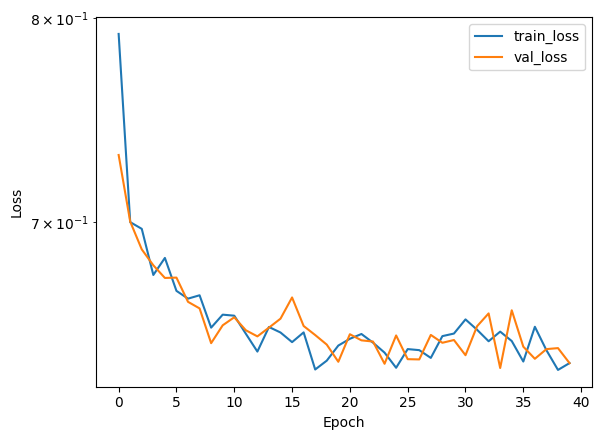

In [12]:
plt.plot(epoch_train_loss, label="train_loss")
plt.plot(epoch_val_loss, label="val_loss")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
sample_count = 1000

In [18]:
initial_latents = torch.randn(sample_count, N_FEATURES, device=device)
initial_latents_reshaped = initial_latents.view(sample_count, *IMG_SHAPE)
    
samples_reshaped = edm_sampler(model_trained, initial_latents_reshaped, num_steps=50, S_churn=40)

samples = samples_reshaped.view(sample_count, N_FEATURES).detach().numpy()

print(f"Successfully generated {sample_count} samples.")
print("Shape of generated data (original format):", samples.shape)

: 

In [ ]:
# real data (not in batches)
real, real_l = datasetraw[:, :-1], datasetraw[:, -1][:, None]

scaler = preprocessing.StandardScaler().fit(real)

real = scaler.transform(real)

if isinstance(real, torch.Tensor):
    real = real.cpu().numpy()

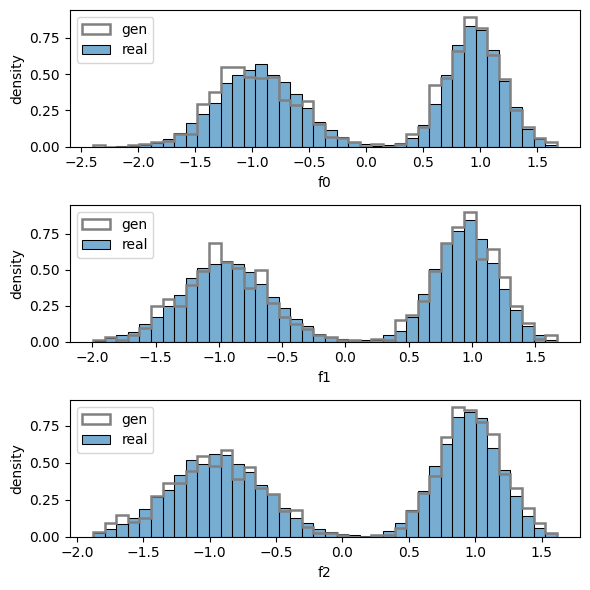

In [ ]:
features_list = globals().get("features_syn", [f"f{i}" for i in range(N_FEATURES)])

fig, axes = plt.subplots(N_FEATURES, 1, figsize=(6, 2 * N_FEATURES), sharex=False)
if N_FEATURES == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    combined = np.concatenate([real[:, idx], samples[:, idx]])
    bins = np.histogram_bin_edges(samples[:, idx], bins=40)

    sns.histplot(
        real[:, idx],
        bins=bins,
        ax=ax,
        stat="density",
        color="C0",
        alpha=0.6,
        label="real",
    )
    ax.hist(
        samples[:, idx],
        bins=bins,
        density=True,
        histtype="step",
        lw=1.8,
        color="gray",
        label="gen",
    )

    ax.set_xlabel(features_list[idx])
    ax.set_ylabel("density")
    ax.legend()

plt.tight_layout()
plt.show()